In [1]:
from extraction import *
from  imgutil import *
from  measurment import *
from  mlmeasurment import *
from plots import *
from  cellvis import *

# Input parameters

In [2]:
image_path = 'DAPI_cells.jpg'
channel_for_masking = 2
cell_object_list_path = None
coloc_channels = [0,2]
morph_props = ('feret_diameter_max', 'perimeter', 'eccentricity')
features_for_ml = ['feret_diameter_max', 'perimeter', 'eccentricity']
columns_for_plotting = ['feret_diameter_max', 'perimeter', 'mean_intensity', 'cor_coefficient']
show_step = 4
values_to_show_on_fig = ['mean_intensity', 'cor_coefficient', 'KMeans_label']


# Image loading, cell extraction, primiry filtering and creating a lost of cell objects 

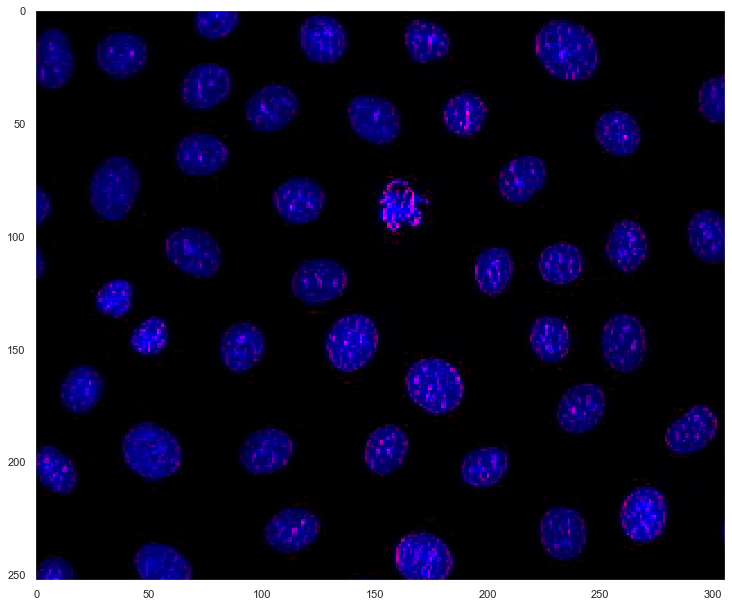

In [3]:
image, image_hash = image_loader(image_path)
path_to_save = (r'figures/'+str(image_hash))

show_image(image, "original image")

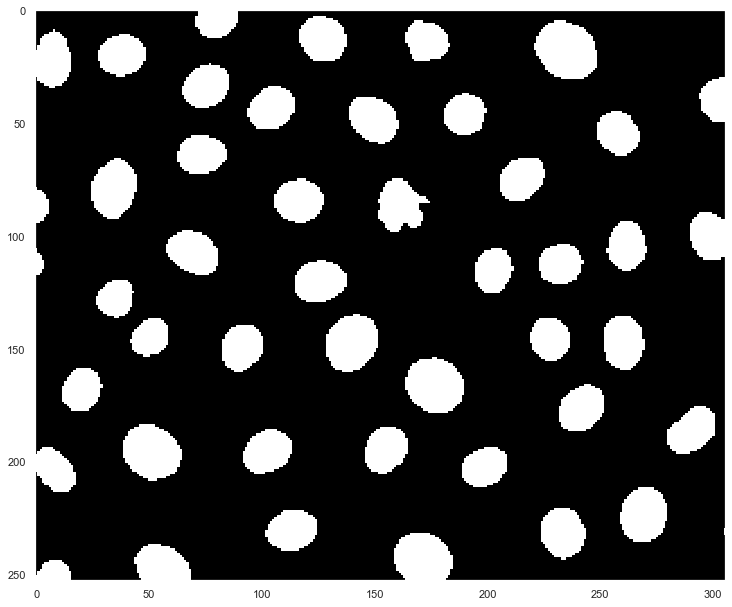

In [4]:
########
# any localisation and thresholding algorithm can be put here 

mask = thresholder(image,channel=channel_for_masking)
show_image(mask, "mask")

contours, bounding_boxes = object_bounding_boxes(mask,detector,1)
########

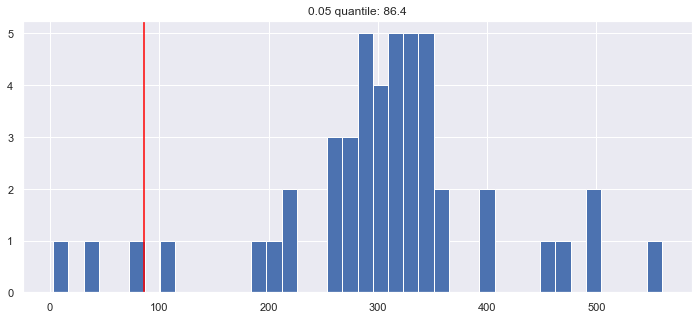

In [5]:
cell_list = create_cell_list(bounding_boxes, image, mask, image_hash, contours)

cell_list  = filter_cell_objects_by_size(cell_list, image, show_hist=True, quantile=0.05)

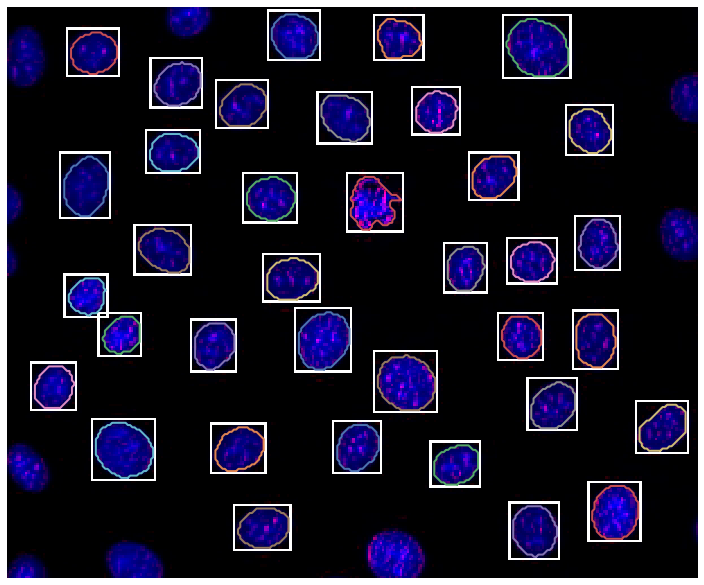

In [6]:
show_contours_and_boxes_on_image(image, cell_list )
save_objects_as_pickle(cell_list, 'cell_list')
save_objects_as_tiff(cell_list, f'{image_hash}_stack')

# Per cell measurment with custom metrics

In [7]:
#Opening file and unpickling its content if needed
if cell_object_list_path:
    with open(cell_object_list_path , 'rb') as pickled_file:
        cell_list = pickle.load(pickled_file)

# Sequantial calculating data for cell objects
cell_list = add_measured_value(cell_list, calculate_morpho_properties,properties=(morph_props))
cell_list = add_measured_value(cell_list, calc_center_of_mass)
cell_list = add_measured_value(cell_list, calculate_intensity)
cell_list = add_measured_value(cell_list, calculate_colocalization, channels=coloc_channels, use_mask=True)

save_objects_as_pickle(cell_list, 'cell_list_for_labeling')

df = create_df(cell_list)

df.to_csv(f'csvs/{cell_list[0].original_image_hash}.csv', index=False)  

# Model traning if needed and per cell ML measurment

In [8]:
# Training a model on whole image data set
model, scaler =  fit_KMeans(df[features_for_ml])
# per cell model inference
new_cell_list = add_measured_value(cell_list, calculate_label_KMeans, model=model,
                                   scaler=scaler,  features=features_for_ml)
save_objects_as_pickle(cell_list, 'cell_list_for_labeling')

# Plotting features 

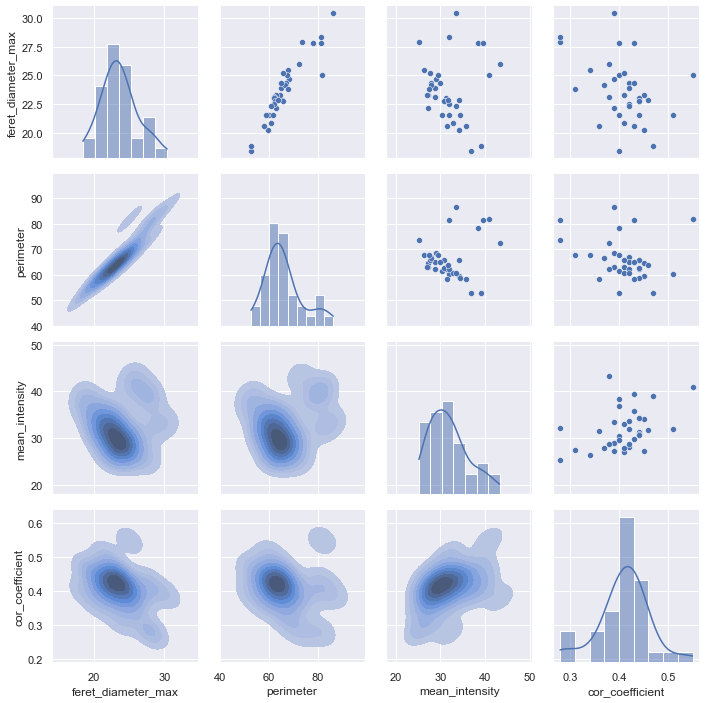

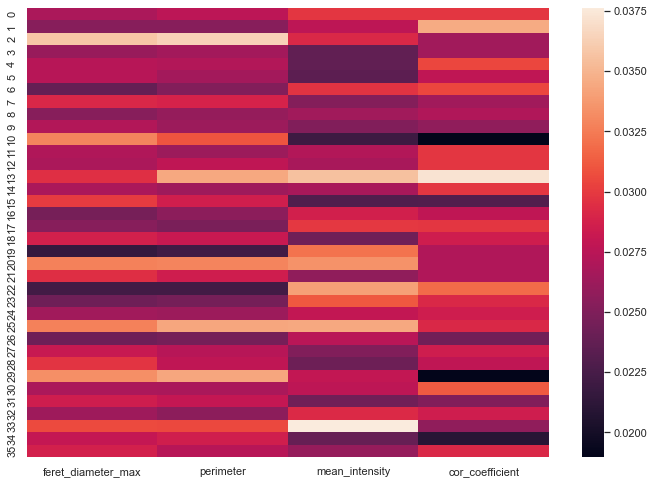

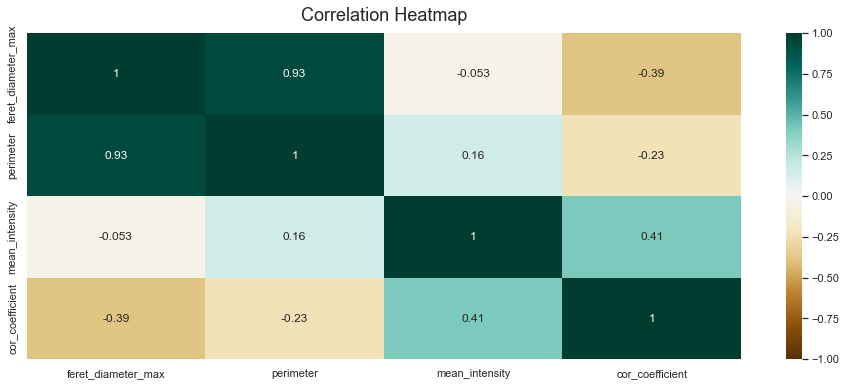

In [9]:
columns_list = df.columns
df.describe()
pair_grid(df, columns_for_plotting)
heat_map(df, columns_for_plotting )
correlation_heat_map(df, columns_for_plotting )

# Visualization on image and cells montage creation

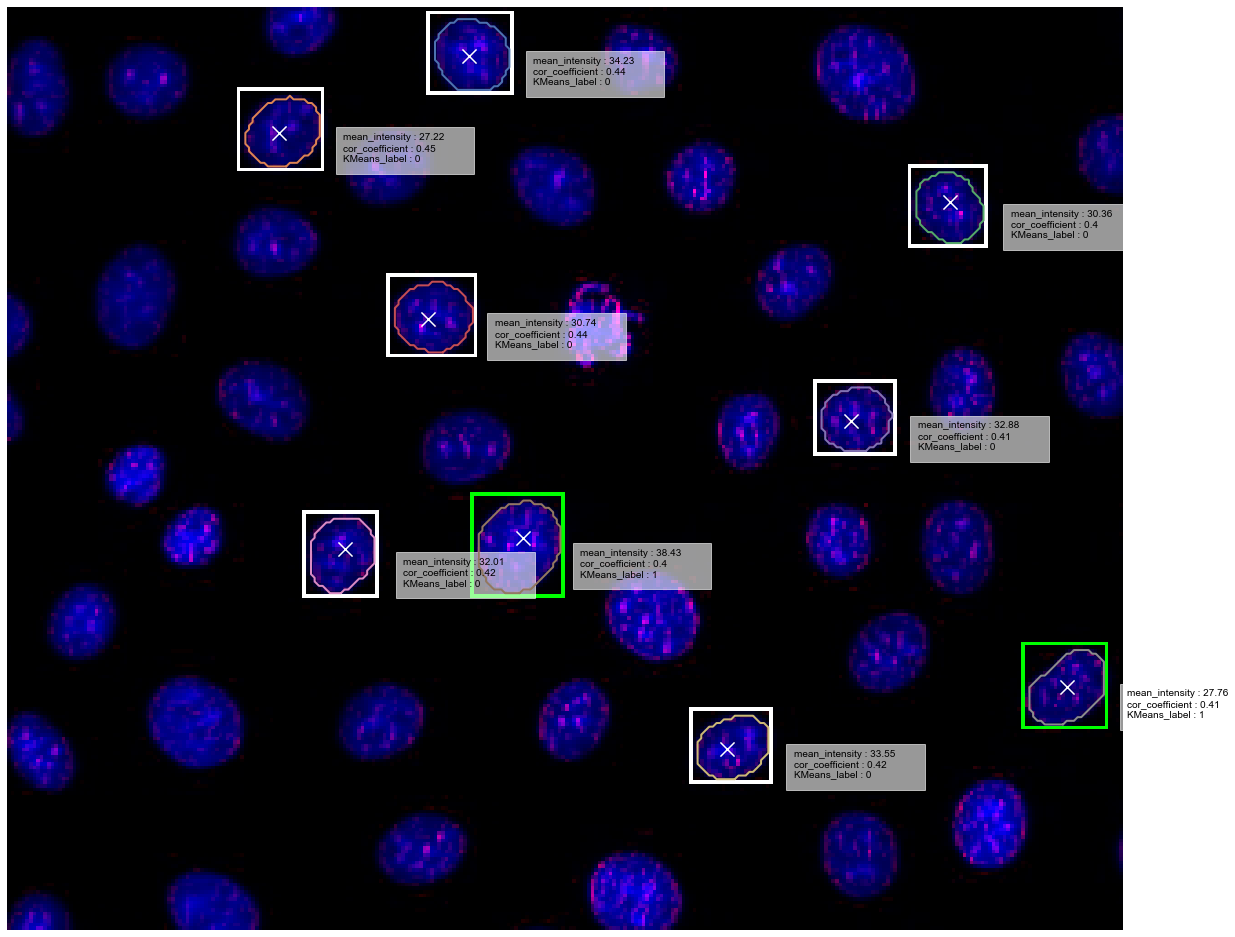

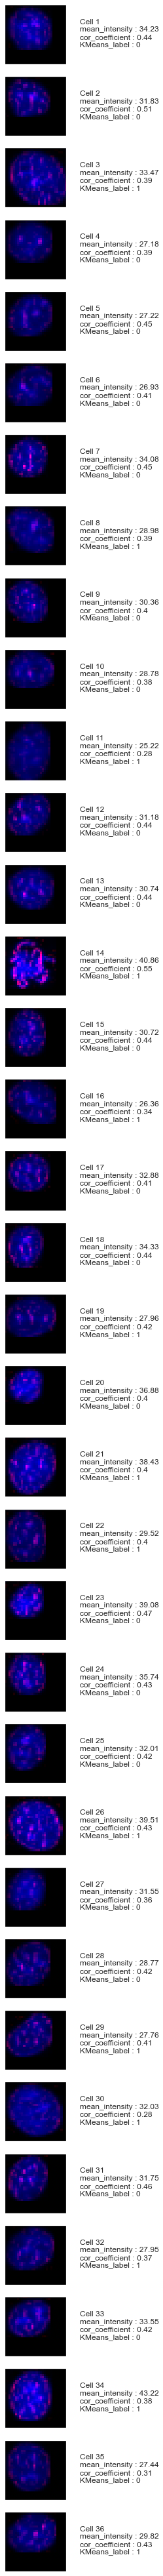

In [10]:
labeling_image(image,image_hash, cell_list[::show_step], values_to_show_on_fig)
make_montage(cell_list,values_to_show_on_fig,path_to_save, 3)